In [49]:
import pandas as pd


url = "https://www.insee.fr/fr/statistiques/fichier/4648335/TF106.csv"

df = pd.read_csv(url, sep=";")

In [50]:
# filtering values with exactly 3 characters, corresponding to ECOICOP groups
df = df.loc[df['NOMENCLATURE'].str.len() == 3]

In [51]:
# filtering out rows where the "FCOIC" value starts with "13"
df = df.loc[~df['NOMENCLATURE'].str.startswith('13')]

Now let's deal with Eurostat inflation stats.

In [52]:
import pandas as pd
import eurostat

In [53]:
df_inflation = eurostat.get_data_df(code="PRC_HICP_MANR", filter_pars={
                                    'geo': 'FR', 'startPeriod': "2021-03"})
df_inflation = df_inflation.rename(columns={'geo\TIME_PERIOD': 'geo'})

In [54]:
# filter the rows using a regular expression, keeping only the ECOICOP groups (3 numbers)
df_inflation = df_inflation[df_inflation['coicop'].str.match(r'^CP\d{3}$')]

In [55]:
# remove the "CP" prefix from the values in the coicop column
df_inflation['coicop'] = df_inflation['coicop'].str.slice(start=2)

In [56]:
# keep only the specified columns using the .loc[] indexer
df_inflation = df_inflation.loc[:, ['coicop', '2022-03', '2023-03']]

In [57]:
# calculate the Cumulated inflation column based on the values in 2022-03 and 2023-03
df_inflation['Cumulated'] = (
    (1 + (df_inflation['2022-03'] / 100)) * (1 + (df_inflation['2023-03'] / 100))-1)*100

In [58]:
merged = pd.merge(df, df_inflation, left_on='NOMENCLATURE', right_on="coicop")

In [59]:
# calculating the sum of "CONSO" for each unique value in "DECUC" column
sum_by_decuc = merged.groupby('DECUC')['CONSO'].sum()

In [60]:
# adding a new column "PROP" with the percentage of each row relative to the sum for each unique value in "DECUC" column
merged['PROP'] = merged['CONSO'] / merged['DECUC'].map(sum_by_decuc)

Let's make sure sumPROP is equal to 1

In [61]:
sumPROP = merged.groupby('DECUC')['PROP'].sum()
sumPROP

DECUC
1      1.0
10     1.0
2      1.0
3      1.0
4      1.0
5      1.0
6      1.0
7      1.0
8      1.0
9      1.0
TOT    1.0
Name: PROP, dtype: float64

In [62]:
# calculate the weight_Group_inflation_2022_03 column based on 2022-03 and PROP
merged['weight_Group_inflation_2022_03'] = merged['2022-03'] * merged['PROP']

In [63]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_2023_03'] = merged['2023-03'] * merged['PROP']

In [64]:
# calculate the weight_Group_inflation_2023_03 column based on 2023-03 and PROP
merged['weight_Group_inflation_Cumulated'] = merged['Cumulated'] * merged['PROP']

In [65]:
sumInflationMarch2022 = merged.groupby(
    'DECUC')['weight_Group_inflation_2022_03'].sum().to_frame()

In [66]:
sumInflationMarch2023 = merged.groupby(
    'DECUC')['weight_Group_inflation_2023_03'].sum().to_frame()

In [67]:
sumCumulated = merged.groupby(
    'DECUC')['weight_Group_inflation_Cumulated'].sum().to_frame()

Let's compute the difference with the ensemble

In [68]:
sumInflationMarch2022['diffTOT'] = sumInflationMarch2022["weight_Group_inflation_2022_03"] - \
    sumInflationMarch2022.loc['TOT']["weight_Group_inflation_2022_03"]
sumInflationMarch2022 = sumInflationMarch2022.drop(labels='TOT')

In [69]:
sumInflationMarch2023['diffTOT'] = sumInflationMarch2023["weight_Group_inflation_2023_03"] - \
    sumInflationMarch2023.loc['TOT']["weight_Group_inflation_2023_03"]
sumInflationMarch2023 = sumInflationMarch2023.drop(labels='TOT')

In [70]:
sumCumulated['diffTOT'] = sumCumulated["weight_Group_inflation_Cumulated"] - \
    sumCumulated.loc['TOT']["weight_Group_inflation_Cumulated"]
sumCumulated = sumCumulated.drop(labels='TOT')

In [71]:
sumAllThree = sumInflationMarch2022.merge(sumInflationMarch2023, on="DECUC", suffixes=[
                                          "_2022", "_2023"]).merge(sumCumulated, on="DECUC")

In [72]:
sumAllThree = sumAllThree.sort_index(key=lambda x: pd.to_numeric(x))

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_19660\2748133953.py:33: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure6.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


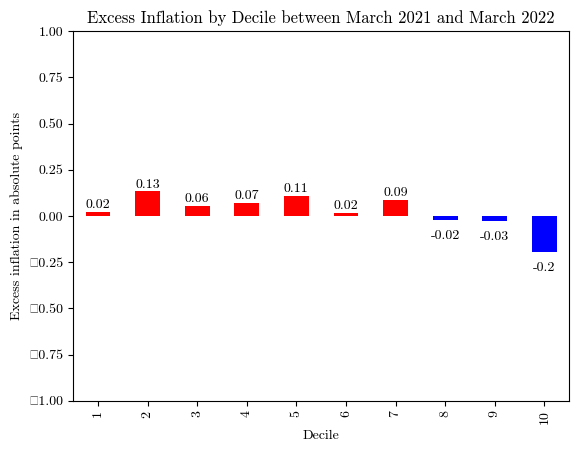

In [73]:
import matplotlib.pyplot as plt
# draw a bar chart

# define the custom ordering of the index values
custom_order = ['D{}'.format(i) for i in range(1, 11)]


# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2022']]


sumAllThree.plot.bar(y='diffTOT_2022', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2021 and March 2022')

# set the y-axis scale to a specific range
plt.ylim(-1, 1)

# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT_2022"]):
    if v >= 0:
        plt.text(i, v+0.02, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.1, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure6.png', dpi=500, bbox_inches='tight')

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_19660\3982799635.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure7.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


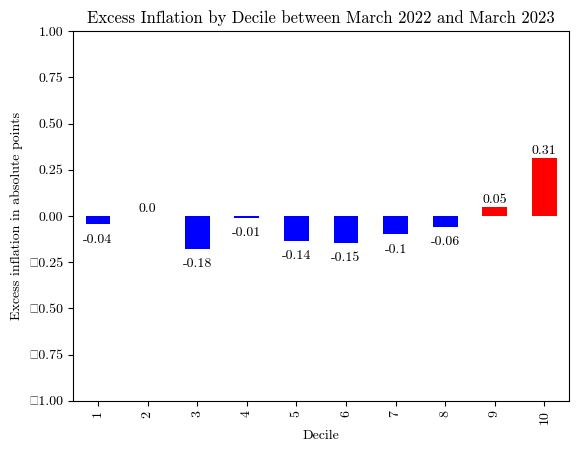

In [74]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT_2023']]


sumAllThree.plot.bar(y='diffTOT_2023', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2022 and March 2023')

# set the y-axis scale to a specific range
plt.ylim(-1, 1)

# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT_2023"]):
    if v >= 0:
        plt.text(i, v+0.02, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.1, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure7.png', dpi=500, bbox_inches='tight')

C:\Users\mdaversa\AppData\Local\Temp\ipykernel_19660\2986281216.py:26: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.savefig(f'saved_figs/figure8.png', dpi=500, bbox_inches='tight')
C:\Users\mdaversa\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


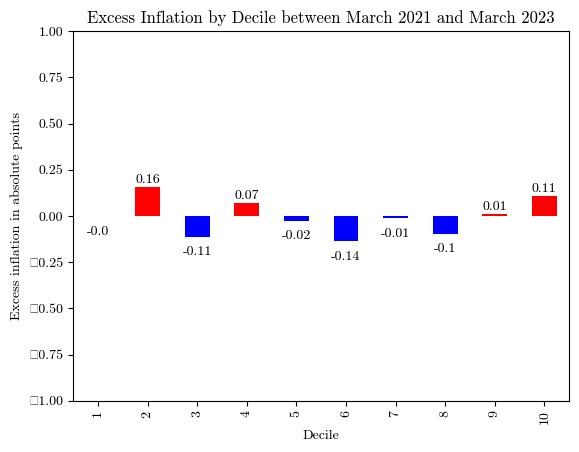

In [75]:
# define the colors based on the value of each bar
colors = ['red' if x > 0 else 'blue' for x in sumAllThree['diffTOT']]


sumAllThree.plot.bar(y='diffTOT', color=colors)

# set axis labels and title
plt.xlabel('Decile')
plt.ylabel('Excess inflation in absolute points')
plt.title('Excess Inflation by Decile between March 2021 and March 2023')

# set the y-axis scale to a specific range
plt.ylim(-1, 1)

# Add values to each bar
for i, v in enumerate(sumAllThree["diffTOT"]):
    if v >= 0:
        plt.text(i, v+0.02, str(round(v,2)), ha='center', fontweight='bold')
    else:
        plt.text(i, v-0.1, str(round(v,2)), ha='center', fontweight='bold')

# remove the legend entirely
plt.legend(frameon=False, labels=[])

plt.rcParams['font.family'] = 'cmr10'
plt.savefig(f'saved_figs/figure8.png', dpi=500, bbox_inches='tight')

In [76]:
sumInflationMarch2022.to_csv("computed_data/106_inflation_March_2022.csv")
